В цьому домашньому завданні ми проведемо додаткові експерименти для рішення задачі бінарної класифікації і створимо ваш новий submission на змагання на Kaggle.

-----------


**Завдання 0**. Завантажте дані `train.csv`, `test.csv`, `sample_submission.csv` зі змагання на Kaggle ["Bank Customer Churn Prediction (DLU Course)"](https://www.kaggle.com/competitions/bank-customer-churn-prediction-dlu-course-c-2). Для завантаження потрібно долучитись до змагання (натиснути кнопку "Join").

**Завдання 1**. **Збираємо весь код з попереднього ДЗ в одному місці.** В лекційному ноутбуці `Логістична регресія з ScikitLearn. Повна ML задача.ipynb` ми познайомились з поняттям пайплайнів, а також я показала, як компактно виглядає рішення МЛ задачі, якщо ми зберемо весь код разом.

Оскільки ми далі будемо робити експерименти, які включають ті самі етапи попередньої обробки, але інше моделювання - буде зручно мати весь код компактно і під рукою. Тому зараз ми займемось збором коду до купи :) Після цього завдання для подальших експериментів ви можете перенести частини розвʼязку взагалі в окремий `.py` файл, аби було зручно імпортувати функції.

Зі свого рішення в попередньому домашньому завданні (`Логістична регресія з scikit learn.ipynb`) зберіть усі кроки розвʼязку задачі разом з використанням `sklearn.Pipeline` за прикладом з лекції.

Ваш код нижче має містити
1. Читання даних з файлу (поза пайплайном).
2. Розбиття на тренувальний і валідаційний набори, де валідаційний містить 20% даних (поза пайплайном).
3. Виділення категоріальних і числових колонок (поза пайплайном).
4. Підготовку категоріальних і числових колонок (частина пайплайну). В прикладі в лекції ми оформлювали обробку числових і категоріальних колонок в окремі трансформери `numeric_transformer`, `categorical_cols`. Рекоемндую зробити саме так, так потім зручніше вносити зміни :)
5. Тренування лог регресії (частина пайплайну).
6. Запуск пайплайну на тренування на трен. даних (поза пайплайном).
7. Запуск пайплайну на передбачення на трен і вал. даних і вимір метрик якості ROC-AUC + вивдення Confusion Matrix (поза пайплайном).
8. Збереження моделі в формат joblib (поза пайплайном).

Ви це все вже зробили в попереднтьому ДЗ! Тож, тут просто заадча все зібрати разом.

Нижче я додала підказки, що покроково ви маєте зробити. Якщо ви почуваєтесь впевнено, можете видалити ці підказки і реалізувати все самостійно, або ж - просто заповнити пропуски.

Завдання оцінюється в 10 балів. Головний результат - аби код в фіналі був робочий. Бо за не робочий нам гроші ніхто не заплатить :)

In [65]:
import joblib
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score, f1_score, accuracy_score
from src.utils import predict_and_plot

Area under ROC score on Training dataset: 86.21%


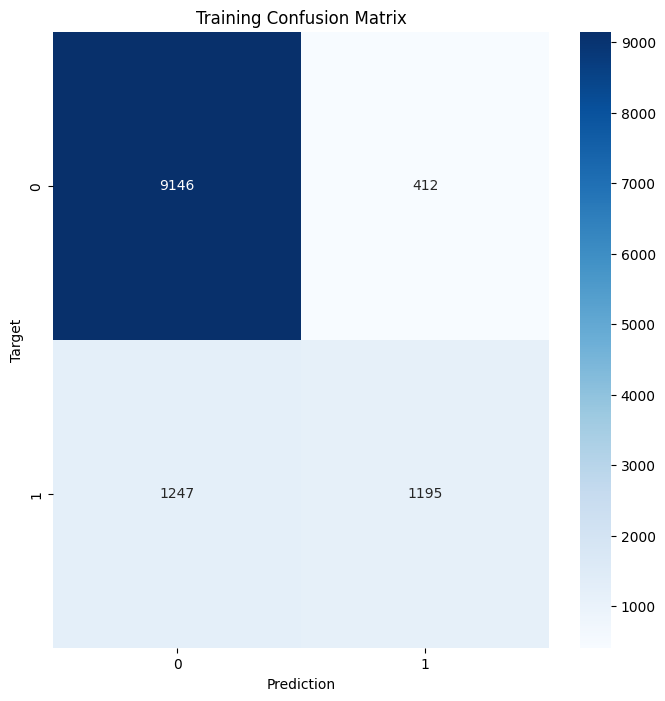

Area under ROC score on Validation dataset: 86.36%


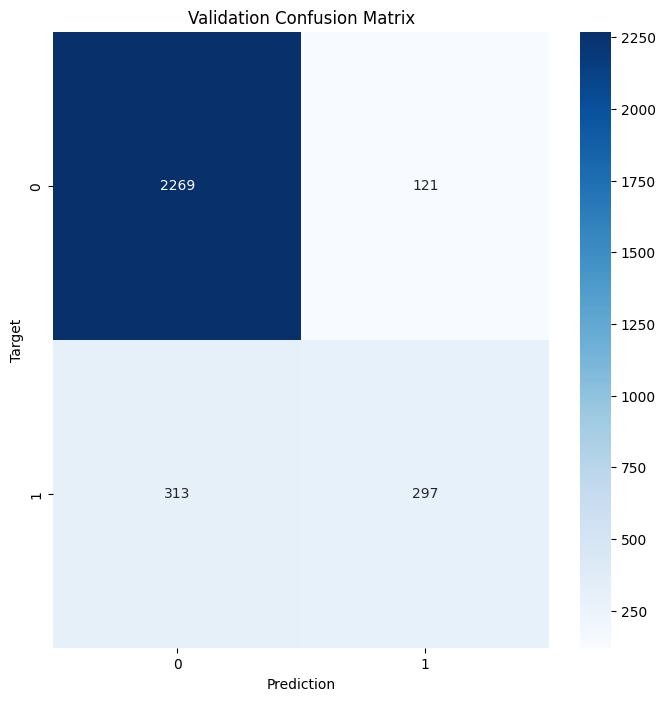

['bank-customer-churn-prediction-dlu-course-c-2/bank_customer_pipeline.joblib']

In [66]:
raw_df = pd.read_csv("bank-customer-churn-prediction-dlu-course-c-2/train.csv", index_col=0)

assert 'Surname' in raw_df.columns, "Surname column not found in dataset."
raw_df.drop(columns=['Surname'], inplace=True)
# raw_df['Surname'] = raw_df['Surname'].apply(lambda x: x[1])

# Create train and validation data sets
input_cols = raw_df.select_dtypes('number').columns[1:-1]
target_col = raw_df.columns[-1]
train_df, val_df = train_test_split(raw_df, test_size=0.2, random_state=42, stratify=raw_df[target_col])
train_inputs, train_targets = train_df[input_cols], train_df[target_col]
val_inputs, val_targets = val_df[input_cols], val_df[target_col]

# Identify numerical and categorical columns
numeric_cols = train_inputs.select_dtypes('number').columns.tolist()
categorical_cols = train_inputs.select_dtypes('object').columns.tolist()

# Create pipelines (transformers) for numerical and categorical columns
numeric_transformer = Pipeline([
    ('scaler', StandardScaler()),
])
categorical_transformer = Pipeline([
    ('encoder', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

# Combine transformers for different types of collumns into one preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('numerical', numeric_transformer, numeric_cols),
        ('categorical', categorical_transformer, categorical_cols)
    ]
)

# Create pipeline that gonna start preprocessing first and than train model
model_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LogisticRegression(solver='liblinear'))
])

# Running pipeline
model_pipeline.fit(train_inputs, train_targets)

# Evaluate model on train and validation data sets
train_preds = predict_and_plot(model_pipeline, train_inputs, train_targets, name="Training")
val_preds = predict_and_plot(model_pipeline, val_inputs, val_targets, name="Validation")

joblib.dump(model_pipeline, "bank-customer-churn-prediction-dlu-course-c-2/bank_customer_pipeline.joblib")

**Завдання 2**. Такс, у нас з вами є вже готовий пайплайн. Давайте проведемо нові експерименти.

  Додайте в попередню обробку числових колонок генерацію polinomal features до степені 2 включно. Для цього створіть новий препроцесор і створіть новий пайплайн.

  Запустіть пайплайн на тренування і виведіть метрики для тренувального і валідаційного набору. Напишіть, як вам модель? Чи спостерігається в цій моделі overfit чи underfit? Чи ця модель добре генералізує?

Area under ROC score on Training Poly dataset: 91.83%


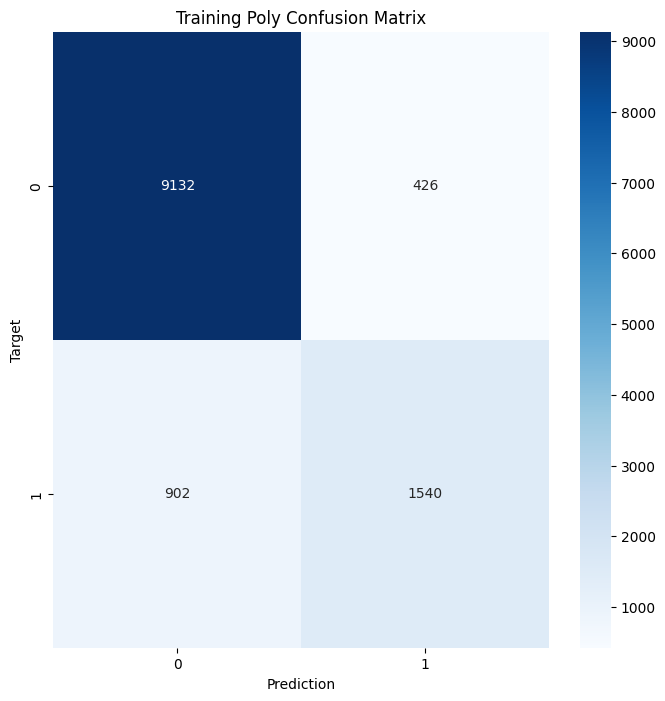

Area under ROC score on Validation Poly dataset: 91.55%


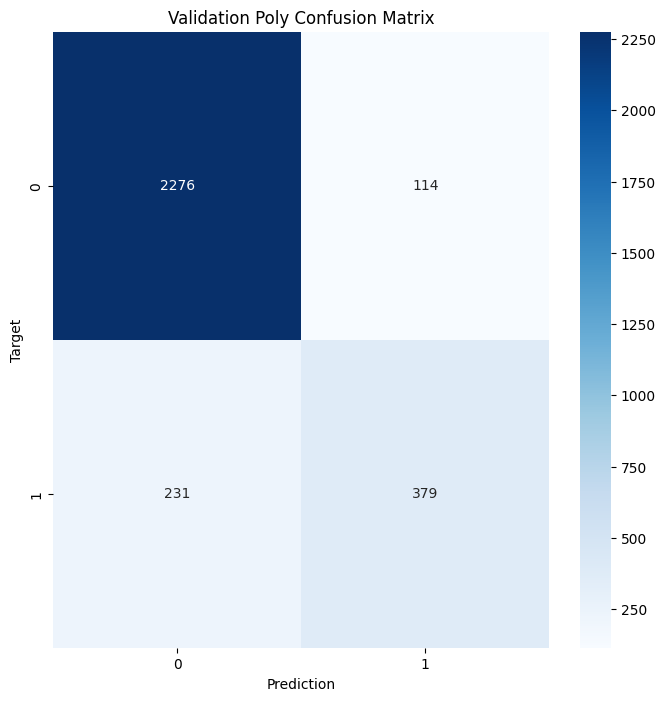

In [67]:
numeric_transformer_poly = Pipeline([
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('scaler', StandardScaler())
])

preprocessor_poly = ColumnTransformer(
    transformers=[
        ('numerical', numeric_transformer_poly, numeric_cols),
        ('categorical', categorical_transformer, categorical_cols),
    ]
)

model_pipeline_poly = Pipeline([
    ('preprocessor', preprocessor_poly),
    ('model', LogisticRegression(solver="liblinear"))
])

model_pipeline_poly.fit(train_inputs, train_targets)

train_preds_poly = predict_and_plot(model_pipeline_poly, train_inputs, train_targets, "Training Poly")
val_preds_poly = predict_and_plot(model_pipeline_poly, val_inputs, val_targets, "Validation Poly")

**Висновок**

Модель не погана. Не можу сказати що спостерігається Underfit чи Overfit. Модель не погано генералізує.

Area under ROC score on Training Poly dataset: 92.61%


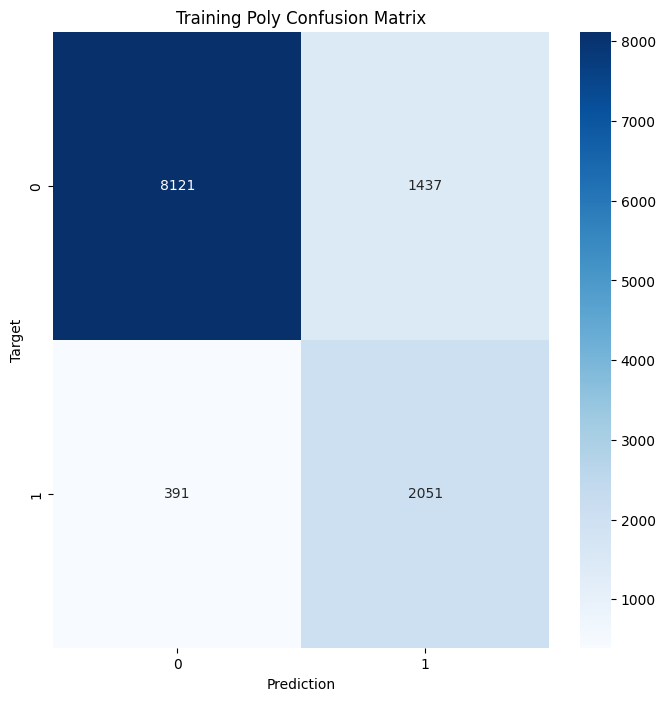

Area under ROC score on Validation Poly dataset: 92.22%


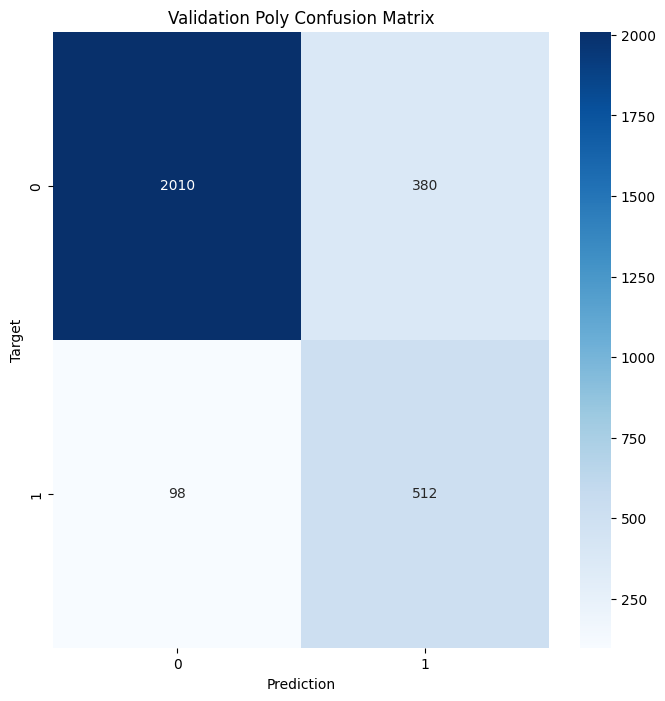

In [68]:
numeric_transformer_poly_3 = Pipeline([
    ('poly', PolynomialFeatures(degree=3, include_bias=False)),
    ('scaler', StandardScaler())
])

preprocessor_poly_3 = ColumnTransformer(
    transformers=[
        ('numerical', numeric_transformer_poly_3, numeric_cols),
        ('categorical', categorical_transformer, categorical_cols),
    ]
)

model_pipeline_poly_3 = Pipeline([
    ('preprocessor', preprocessor_poly_3),
    ('model', LogisticRegression(solver="liblinear", class_weight='balanced', penalty="l1", C=1.0))
])

model_pipeline_poly_3.fit(train_inputs, train_targets)

train_preds_poly_3 = predict_and_plot(model_pipeline_poly_3, train_inputs, train_targets, "Training Poly")
val_preds_poly_3 = predict_and_plot(model_pipeline_poly_3, val_inputs, val_targets, "Validation Poly")

**Висновок**

Поліноміальні ознаки значно покращили модель. Засабмітив.

In [69]:
from src.utils import gen_submission_sample

gen_submission_sample(model_pipeline_poly_3)

**Завдання 4. Перенавчання і регуляризація**.

  Скачайте набір даних `regression_data.csv`. Звичайте набір даних з `regression_data.csv`, розбийте на train і test (в тест 20%) і натренуйте модель лінійної регресії з масштабуванням числових ознак і поліноміальними ознаками до степені **5 включно**.

  Виміряйте якість прогностичної моделі і зробіть висновок, чи модель хороша, чи вона добре генералізує?


In [70]:
from sklearn.metrics import root_mean_squared_error, r2_score

reg_raw_df = pd.read_csv("regression_data.csv")

def train_and_evaluate(model, train_inputs, train_targets, test_inputs, test_targets, poly=None):
    numeric_cols = train_inputs.select_dtypes('number').columns.tolist()
    numeric_transformer = Pipeline([
        ('poly', poly),
        ('scaler', StandardScaler()),
    ])
    preprocessor = ColumnTransformer(
        transformers=[
            ('numerical', numeric_transformer, numeric_cols),
        ]
    )
    model_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model),
    ])
    model_pipeline.fit(train_inputs, train_targets)
    train_preds = model_pipeline.predict(train_inputs)
    test_preds = model_pipeline.predict(test_inputs)
    train_rmse = round(root_mean_squared_error(train_targets, train_preds), 5)
    test_rmse = round(root_mean_squared_error(test_targets, test_preds), 5)
    train_r2 = round(r2_score(train_targets, train_preds), 5)
    test_r2 = round(r2_score(test_targets, test_preds), 5)
    return train_rmse, train_r2, test_rmse, test_r2


input_cols, target_col = reg_raw_df.columns[:-1], reg_raw_df.columns[-1]
train_df, test_df = train_test_split(reg_raw_df, test_size=0.2, random_state=42)

train_inputs, train_targets = train_df[input_cols], train_df[target_col]
test_inputs, test_targets = test_df[input_cols], test_df[target_col]

train_rmse, train_r2, test_rmse, test_r2 = train_and_evaluate(
    LinearRegression(),
    train_inputs,
    train_targets,
    test_inputs,
    test_targets,
    PolynomialFeatures(degree=5, include_bias=False)
)

train_rmse, train_r2, test_rmse, test_r2

(0.0, 1.0, 12.6767, 0.93112)

**Висновок**

- Застосувавши PolynomialFeatures виглядає, що модель перееавчилась. Так як вона дуже точно фітиться з тренувальними даними та не дуже добре передбачає на тестувальних даних. Про це і свідчить тренувальний RMSE=1.

**Завдання 5**. Натренуйте моделі Lasso(), Ridge(), ElasaticNet() на цих даних (з поліном ознаками до степені 20 включно), порівняйте якість з тою, яка була отримана з лінійною регресією. Яка модель найкраще генералізує і чому на ваш погляд (можливо треба буде для відповіді зробити додатковий аналіз ознак)?

In [71]:
from sklearn.linear_model import Lasso, Ridge, ElasticNet

models = {
    "Linear Regression": LinearRegression(),
    "Lasso": Lasso(alpha=0.1, max_iter=1000),
    "Ridge": Ridge(alpha=1.0),
    "ElasticNet": ElasticNet(alpha=0.1, l1_ratio=0.5, max_iter=10000)
}

poly = PolynomialFeatures(degree=20, include_bias=False)

for name, model in models.items():
    train_rmse, train_r2, test_rmse, test_r2 = train_and_evaluate(model, train_inputs, train_targets, test_inputs, test_targets, poly)
    print(f"Model name: {name}")
    print(f"Train RMSE: {train_rmse}, Train R2: {train_r2}, Test RMSE: {test_rmse}, Test R2: {test_r2}")

Model name: Linear Regression
Train RMSE: 0.0, Train R2: 1.0, Test RMSE: 65.39118, Test R2: -0.83278
Model name: Lasso
Train RMSE: 0.96454, Train R2: 0.99952, Test RMSE: 1.27709, Test R2: 0.9993
Model name: Ridge
Train RMSE: 1.05367, Train R2: 0.99943, Test RMSE: 27.7976, Test R2: 0.6688
Model name: ElasticNet
Train RMSE: 3.25714, Train R2: 0.99455, Test RMSE: 7.4709, Test R2: 0.97608


**Висновок**

Найкраще генералізує модель Lasso: RMSE на тестувальних даних всього 1.27709, що дуже близьке за значенням до тренувального RMSE.
Виглядає, що поліноміальні ознаки до такого високого ступення дуже сильно збільшмлм складність моделі, яка в результаті зафітилась під кожну точку. Lasso обнуляє не важливі ознаки, тож виглядає, що було дуже багато таких ознак. L2 регуляризація тільки зменшує ваги, але не обнуляє, що і показують метрики: RMSE менший ніж у LinearRegression. Стосовно ElasticNet, що є комбінацією L1 + L2 - також показав не поганий результат. Проте у датасеті немає високої мультиколінеарності, у випадку коли цей метод ефективний.